## Analysis of energy consumption and production in Estonia
This dataset consists of a sample of solar panel production data

### Import the libraries

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
import pickle
import time

### LightGBM model - Train on energy production data (solar sample)

#### 1. Load the data

In [2]:
dtypes_dict = {
    'datetime': 'datetime64[ns]',
    'hour': 'int64',
    'week_num': 'int64',
    'working_day': 'int64',
    'county': 'int64',
    'is_business': 'int64',
    'product_type': 'int64',
    'is_consumption': 'int64',
    'code': 'int64',
    'prediction_unit_id': 'int64',
    'euros_per_mwh': 'float64',
    'mwh_mean': 'float64',
    'eic_count': 'float64',
    'installed_capacity': 'float64',
    'temperature': 'float64',
    'dewpoint': 'float64',
    'rain': 'float64',
    'snowfall': 'float64',
    'surface_pressure': 'float64',
    'cloudcover_total': 'float64',
    'cloudcover_low': 'float64',
    'cloudcover_mid': 'float64',
    'cloudcover_high': 'float64',
    'windspeed_10m': 'float64',
    'winddirection_10m': 'float64',
    'shortwave_radiation': 'float64',
    'direct_solar_radiation': 'float64',
    'diffuse_radiation': 'float64',
    'target': 'float64'
}

In [10]:
df = pd.read_csv('train_solar_sample.csv')

In [5]:
df.dtypes

datetime                   object
hour                        int64
week_num                    int64
working_day                 int64
county                      int64
is_business                 int64
product_type                int64
is_consumption              int64
code                        int64
prediction_unit_id          int64
euros_per_mwh             float64
mwh_mean                  float64
eic_count                 float64
installed_capacity        float64
temperature               float64
dewpoint                  float64
rain                      float64
snowfall                  float64
surface_pressure          float64
cloudcover_total          float64
cloudcover_low            float64
cloudcover_mid            float64
cloudcover_high           float64
windspeed_10m             float64
winddirection_10m         float64
shortwave_radiation       float64
direct_solar_radiation    float64
diffuse_radiation         float64
target                    float64
dtype: object

#### 2. Preprocess columns for LightGBM model

In [11]:
# Assuming 'df' is your DataFrame with the specified columns
df['datetime'] = pd.to_datetime(df['datetime'])
# Extract relevant components
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Rename 3 columns
df.rename(columns={'datetime': 'prediction_datetime', 'shortwave_radiation': 'surface_solar_radiation_downwards'}, inplace=True)


In [4]:
df.head()

,prediction_datetime,hour,week_num,working_day,county,is_business,product_type,is_consumption,code,prediction_unit_id,euros_per_mwh,mwh_mean,eic_count,installed_capacity,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,surface_solar_radiation_downwards,direct_solar_radiation,diffuse_radiation,target,year,month,day
0,2021-12-27 12:00:00,12,52,1,3,0,3,0,27,12,210.04,103.895,52.0,749.03,-13.0,-14.5,0.0,0.0,1003.8,90.0,100.0,0.0,0.0,1.777778,218.0,78.0,27.0,51.0,5.076,2021,12,27
1,2022-09-26 22:00:00,22,39,1,13,1,3,0,98,52,110.02,207.500,27.0,957.90,8.4,4.0,0.0,0.0,1002.2,31.0,20.0,22.0,0.0,3.611111,321.0,0.0,0.0,0.0,0.000,2022,9,26
2,2022-05-03 08:00:00,8,18,1,11,1,1,0,80,46,90.21,102.500,43.0,1470.20,7.3,1.8,0.0,0.0,992.1,42.0,8.0,58.0,0.0,4.666667,170.0,288.0,157.0,131.0,95.724,2022,5,3
3,2022-06-17 16:00:00,16,24,1,14,1,3,0,105,56,199.81,118.005,76.0,4104.80,19.4,10.4,0.0,0.0,1003.3,35.0,4.0,52.0,0.0,5.583333,153.0,444.0,285.0,159.0,828.123,2022,6,17
4,2022-04-07 08:00:00,8,14,1,11,1,2,0,82,47,151.41,116.880,5.0,100.00,3.9,3.4,0.2,0.0,973.5,100.0,99.0,90.0,100.0,5.305556,248.0,42.0,0.0,42.0,0.290,2022,4,7


#### 3. Select columns to use for the model

In [12]:
# Select applicable columms
cols = ['prediction_datetime', 'hour', 'week_num', 'working_day',
       'county', 'is_business', 'product_type', 'is_consumption', 'code',
       'prediction_unit_id', 'euros_per_mwh', 'mwh_mean', 'eic_count',
       'installed_capacity', 'temperature', 'dewpoint', 'snowfall',
       'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'surface_solar_radiation_downwards',
       'target','year','month', 'day']
df = df[cols]

In [6]:
df.dtypes

prediction_datetime                  datetime64[ns]
hour                                          int64
week_num                                      int64
working_day                                   int64
county                                        int64
is_business                                   int64
product_type                                  int64
is_consumption                                int64
code                                          int64
prediction_unit_id                            int64
euros_per_mwh                               float64
mwh_mean                                    float64
eic_count                                   float64
installed_capacity                          float64
temperature                                 float64
dewpoint                                    float64
snowfall                                    float64
cloudcover_total                            float64
cloudcover_low                              float64
cloudcover_m

#### 4. Use LightGBM model with tuned parameters

In [15]:
# Drop original datetime column and target
X = df.drop(['target','prediction_datetime','is_consumption', 'is_business','prediction_unit_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the data types of the features in the training set
print("Data types of features in the training set:")
print(X_train.dtypes)

# Set the best hyperparameters
best_params = {'learning_rate': 0.2, 'num_leaves': 100}

# Create a LightGBM regressor with best hyperparameters
model = lgb.LGBMRegressor(objective='regression', random_state=42, **best_params)

# Record the start time
start_time = time.time()

# Train the model
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Print the elapsed time
print(f"Training and evaluation time: {elapsed_time} seconds")

Data types of features in the training set:
hour                                   int64
week_num                               int64
working_day                            int64
county                                 int64
product_type                           int64
code                                   int64
euros_per_mwh                        float64
mwh_mean                             float64
eic_count                            float64
installed_capacity                   float64
temperature                          float64
dewpoint                             float64
snowfall                             float64
cloudcover_total                     float64
cloudcover_low                       float64
cloudcover_mid                       float64
cloudcover_high                      float64
surface_solar_radiation_downwards    float64
year                                   int64
month                                  int64
day                                    int64
dtype: obje

### Gradient Boosting - Train on energy production data (solar sample)

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

# Drop original datetime column and target
X = df.drop(['target','prediction_datetime','is_consumption', 'is_business','prediction_unit_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the data types of the features in the training set
print("Data types of features in the training set:")
print(X_train.dtypes)

# Set the best hyperparameters (see further for parameter tuning)
best_params = {'learning_rate': 0.2, 'n_estimators': 100}

# Create a GradientBoostingRegressor with best hyperparameters
model = GradientBoostingRegressor(random_state=42, **best_params)

# Record the start time
start_time = time.time()

# Train the model
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Print the elapsed time
print(f"Training and evaluation time: {elapsed_time} seconds")

Data types of features in the training set:
hour                                   int64
week_num                               int64
working_day                            int64
county                                 int64
product_type                           int64
code                                   int64
euros_per_mwh                        float64
mwh_mean                             float64
eic_count                            float64
installed_capacity                   float64
temperature                          float64
dewpoint                             float64
snowfall                             float64
cloudcover_total                     float64
cloudcover_low                       float64
cloudcover_mid                       float64
cloudcover_high                      float64
surface_solar_radiation_downwards    float64
year                                   int64
month                                  int64
day                                    int64
dtype: obje

#### 0. Tune hyperparameters of a LightGBM model (see above)

In [24]:
# Drop original datetime column and target
X = df.drop(['target','prediction_datetime','is_consumption', 'is_business','prediction_unit_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    # Add other hyperparameters as needed
}

# Create a LightGBM regressor
base_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Initialize grid search with cross-validation
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Record the start time
start_time = time.time()

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Get the best hyperparameters from grid search
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = lgb.LGBMRegressor(objective='regression', random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Print the elapsed time
print(f"Training and evaluation time: {elapsed_time} seconds")

Best Hyperparameters: {'learning_rate': 0.2, 'num_leaves': 100}
Mean Squared Error: 9048.467424311031
Mean Absolute Error: 21.827092663558414
Training and evaluation time: 245.05433225631714 seconds


#### 0. Tune hyperparameters of a Gradient Boosting Model (see above)

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Drop original datetime column and target
X = df.drop(['target','prediction_datetime','is_consumption', 'is_business','prediction_unit_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    # Add other hyperparameters as needed
}

# Create a GradientBoostingRegressor
base_model = GradientBoostingRegressor(random_state=42)

# Initialize grid search with cross-validation
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Record the start time
start_time = time.time()

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Get the best hyperparameters from grid search
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = GradientBoostingRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Print the elapsed time
print(f"Training and evaluation time: {elapsed_time} seconds")

Best Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 200}
Mean Squared Error: 12464.41364944798
Mean Absolute Error: 31.45109072993999
Training and evaluation time: 1230.8567242622375 seconds


### Evaluate 6 other models on Energy production

In [5]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# List of models to try
models = {
    "LightGBM": lgb.LGBMRegressor(objective='regression', random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "CatBoost": cb.CatBoostRegressor(verbose=0, random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Decision Trees": DecisionTreeRegressor(random_state=42)
}

# Drop original datetime column and target
X = df.drop(['target','prediction_datetime','is_consumption', 'is_business','prediction_unit_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over each model
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    
    # Record the start time
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Print the elapsed time
    print(f"Training and evaluation time: {elapsed_time} seconds")
    print()

Training and evaluating LightGBM...
Mean Squared Error: 9846.536495704782
Mean Absolute Error: 25.022088199724102
Training and evaluation time: 3.4435153007507324 seconds

Training and evaluating XGBoost...
Mean Squared Error: 10593.784468962709
Mean Absolute Error: 25.470343101038633
Training and evaluation time: 8.756856918334961 seconds

Training and evaluating CatBoost...
Mean Squared Error: 8252.14802273349
Mean Absolute Error: 23.15684970360955
Training and evaluation time: 18.057881593704224 seconds

Training and evaluating Random Forest...
Mean Squared Error: 11256.553856624487
Mean Absolute Error: 23.881381789537063
Training and evaluation time: 129.27429127693176 seconds

Training and evaluating AdaBoost...
Mean Squared Error: 78885.39620655986
Mean Absolute Error: 171.638968077889
Training and evaluation time: 7.888559341430664 seconds

Training and evaluating Decision Trees...
Mean Squared Error: 20994.16420299445
Mean Absolute Error: 32.875448153599145
Training and evaluat

### Train hyperparameters CatBoost (Best MAE)

In [13]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

# Load your dataframe 'df' and define X and y

# Without parameter tuning
print("Training and evaluating CatBoost without parameter tuning...")
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CatBoost without parameter tuning
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

end_time = time.time()
elapsed_time = end_time - start_time

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Training and evaluation time:", elapsed_time, "seconds")

# With parameter tuning
print("\nTraining and evaluating CatBoost with parameter tuning...")
start_time = time.time()

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Initialize grid search with cross-validation
grid_search = GridSearchCV(estimator=CatBoostRegressor(verbose=0, random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from grid search
best_params = grid_search.best_params_

# Train CatBoost with the best hyperparameters
best_catboost_model = CatBoostRegressor(random_state=42, **best_params, verbose=0)
best_catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

end_time = time.time()
elapsed_time = end_time - start_time

print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Training and evaluation time:", elapsed_time, "seconds")


Training and evaluating CatBoost without parameter tuning...
Mean Squared Error: 8252.14802273349
Mean Absolute Error: 23.15684970360955
Training and evaluation time: 17.977760076522827 seconds

Training and evaluating CatBoost with parameter tuning...
Best Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 200}
Mean Squared Error: 9184.716993078107
Mean Absolute Error: 25.642606882606415
Training and evaluation time: 88.46086859703064 seconds


### Train and Save CatBoost model

#### 1. Load Libraries

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
import pickle
import time

#### 2. Load the Data

In [2]:
df = pd.read_csv('train_solar_sample.csv')

#### 3. Add & Rename columns

In [3]:
# Assuming 'df' is your DataFrame with the specified columns
df['datetime'] = pd.to_datetime(df['datetime'])
# Extract relevant components
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Rename 3 columns
df.rename(columns={'datetime': 'prediction_datetime', 'shortwave_radiation': 'surface_solar_radiation_downwards'}, inplace=True)

#### 4. Select Applicable Columns

In [4]:
# Select applicable columms
cols = ['prediction_datetime', 'hour', 'week_num', 'working_day',
       'county', 'is_business', 'product_type', 'is_consumption', 'code',
       'prediction_unit_id', 'euros_per_mwh', 'mwh_mean', 'eic_count',
       'installed_capacity', 'temperature', 'dewpoint', 'snowfall',
       'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'surface_solar_radiation_downwards',
       'target','year','month', 'day']
df = df[cols]

#### 5. Train the Catboost Model

In [5]:
start_time = time.time()

# Drop original datetime column and target
X = df.drop(['target','prediction_datetime','is_consumption', 'is_business','prediction_unit_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CatBoost without parameter tuning
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

end_time = time.time()
elapsed_time = end_time - start_time

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Training and evaluation time:", elapsed_time, "seconds")

Mean Squared Error: 8252.14802273349
Mean Absolute Error: 23.15684970360955
Training and evaluation time: 18.098368644714355 seconds


#### 6. Save the Catboost Model

In [6]:
# Save the model to a file
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(catboost_model, file)

#### 7. Plot Feature Importance of the CatBoost Model

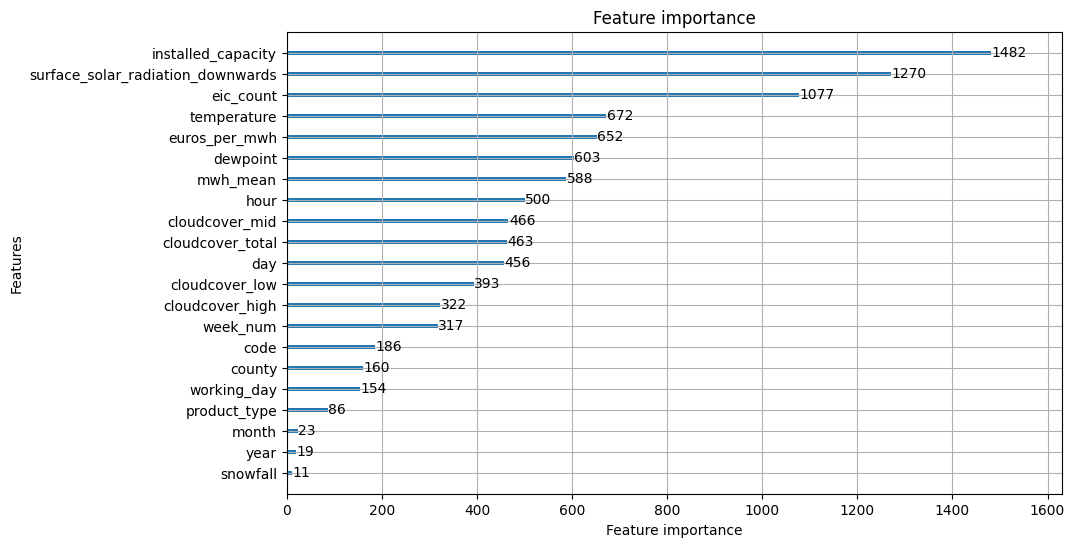

In [9]:
# Plot feature importance
lgb.plot_importance(model, max_num_features=30, figsize=(10, 6), importance_type='split')
plt.show()

### Verify the parameters of the LightGBM Model (see top of notebook)

In [10]:
import lightgbm as lgb

# Load the LightGBM model
model_path_lgb = 'lightgbm_model.pkl'  # Adjust the path accordingly
with open(model_path_lgb, 'rb') as model_file:
    lightgbm_model = pickle.load(model_file)
    
# Check the properties of the loaded model
print("")
print("Model parameters:", lightgbm_model.get_params())  # Print model parameters


Model parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 100, 'objective': 'regression', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


### Gradient Boosting Model - Train on Energy Consumption Data (train_cons)

#### Import Libraries

In [1]:
import sklearn
print("GradientBoostingRegressor version:", sklearn.__version__)

GradientBoostingRegressor version: 1.2.2


In [4]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import time
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

#### Load the Data and Code List

In [5]:
# Read the files
train_cons = pd.read_csv('train_cons.csv', keep_default_na=False)
train_cons['target'] = train_cons['target'].replace('', np.nan).astype(float)
train_cons['datetime'] = pd.to_datetime(train_cons['datetime'])
code_list = pd.read_csv('code_list.csv', keep_default_na=False)
# code_list = pd.read_csv('code_list.csv')
cd_list = code_list['code'].to_list()

### Produce & Save 69 Gradient Boosting Models for all County-is_business-Product_type Combinations

In [6]:
# Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

# Create an empty dictionary to store models and predictions
models_and_predictions = {}

# Iterate through each code in the list
for code in cd_list:
    # Filter the original DataFrame for the specific code
    df_code = train_cons[train_cons['code'] == code].copy()
    
    # Check if df_code is not empty
    if not df_code.empty:
        # Forward fill NaN values in the target column
        df_code['target'].fillna(method='ffill', inplace=True)
        
        # Train-test split
        X = df_code[['temperature', 'working_day', 'hour']]  # Select relevant features
        y = df_code['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=42)
        
        # Create a Gradient Boosting model
        # Best hyperparameters
        best_hyperparameters = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

        # Create a Gradient Boosting model with the best hyperparameters
        model = GradientBoostingRegressor(**best_hyperparameters)
            
        # Fit the model with training data
        model.fit(X_train, y_train)
        
        # Make predictions
        test_predictions = model.predict(X_test)

        # Save the model using pickle with the name model_[code]
        model_name = f'model_{code}.pkl'
        with open(model_name, 'wb') as model_file:
            pickle.dump(model, model_file)

        # Evaluate performance on the test set
        mae = mean_absolute_error(y_test, test_predictions)
        mpe = np.mean((y_test - test_predictions) / y_test) * 100  # Calculate Mean Percentage Error
        
        print(f'Mean Absolute Error on the test set for code {code}: {mae}')
        print(f'Mean Percentage Error on the test set for code {code}: {mpe}%')   
    else:
        print(f"No data available for code {code}, skipping...")

Mean Absolute Error on the test set for code 2: 169.89611336297722
Mean Percentage Error on the test set for code 2: -27.754767070210356%
Mean Absolute Error on the test set for code 4: 6.13597188434752
Mean Percentage Error on the test set for code 4: -25.09189764172386%
Mean Absolute Error on the test set for code 6: 346.4286675757649
Mean Percentage Error on the test set for code 6: -16.25458623002654%
Mean Absolute Error on the test set for code 1: 313.73354593560936
Mean Percentage Error on the test set for code 1: -inf%
Mean Absolute Error on the test set for code 3: 160.07069617259828
Mean Percentage Error on the test set for code 3: -8.48902638791726%
Mean Absolute Error on the test set for code 5: 42.501173345429805
Mean Percentage Error on the test set for code 5: -inf%
Mean Absolute Error on the test set for code 7: 919.0726632571807
Mean Percentage Error on the test set for code 7: -2.6055354792810164%
Mean Absolute Error on the test set for code 9: 3.879178685711897
Mean P